## Assignment-1:train.ipynb
### **Tanmoy Paul**
### *Roll no- MDS202246*

In [1]:
import numpy as np ## importing the library
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Reading the train and test data
train_data=pd.read_csv('train.csv') 
test_data=pd.read_csv('test.csv')

In [3]:
## Getting the predictor features and labels from the train and test set
X_train_sent,y_train=train_data['Processed_text'],train_data['spam']
X_test_sent,y_test=test_data['Processed_text'],test_data['spam']

### Feature Engineering

#### Here we will be using CountVectorizer. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train_sent)

CountVectorizer()

In [5]:
X_train=vectorizer.transform(X_train_sent) ## vectorizing train set
X_test=vectorizer.transform(X_test_sent) ## vectorizing test set

In [6]:
X_train.shape

(4556, 23147)

### Here we are balancing the Train set using "Over Sampling Method" for better training

In [7]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy="minority")
X_train,y_train=smote.fit_resample(X_train,y_train)
y_train.value_counts()

0    3462
1    3462
Name: spam, dtype: int64

<Axes: xlabel='spam', ylabel='count'>

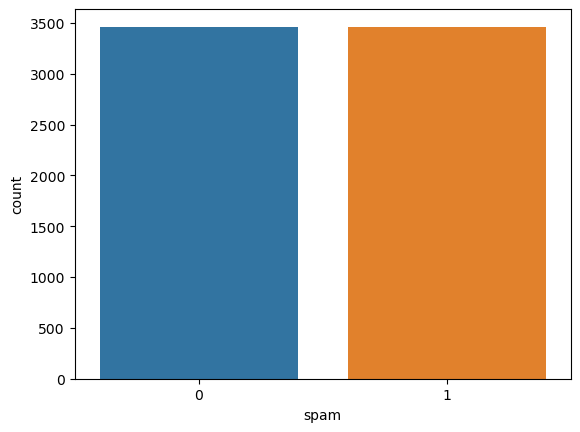

In [8]:
import seaborn as sns
sns.countplot(x=y_train)

### Now the Train set is balanced

In [9]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

### Model 1: Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression() ## Logistic Regression Model

#### *Cross validating* 

In [11]:
scores = cross_val_score(logreg,  # model
                         X_train,  # training data (features)
                         y_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # 
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[0.96825397 0.96969697 0.98701299 0.99422799 0.98843931 0.98843931
 0.98843931 0.9783237  0.99132948 0.97687861]


In [12]:
print("Mean_score:",scores.mean(),"Std:",scores.std())

Mean_score: 0.983104163017458 Std: 0.008683070026630227


#### *Plotting Learning Curve*

In [13]:
## Function to plot learning curve for checking the Training Process
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'd:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

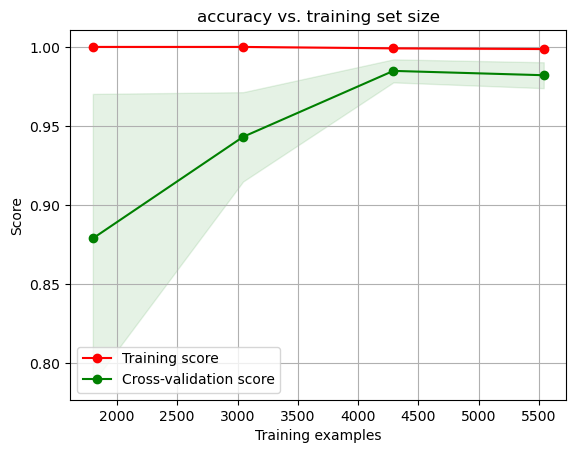

In [14]:
plot_learning_curve(logreg, "accuracy vs. training set size", X_train, y_train, cv=5)

Since performance keeps growing for cross validation scores, we see our model is not complex/flexible enough to capture all nuance, given little data.But still I will be doing GridsearchCV to check if the model needs some regularization or not 

In [15]:
params = {
    'penalty':['l1','l2'] ,
    'C': [0.001,0.005,0.01,0.1,1], ## default is 1
}

grid = GridSearchCV(
    logreg,  # model
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # score to optimized
    cv=StratifiedKFold(n_splits=5),  # type of cross validation to use
)

In [16]:
logreg_detector = grid.fit(X_train, y_train)
print(logreg_detector.best_params_) ## best parameter 

{'C': 1, 'penalty': 'l2'}


It don't need any regularization.

In [17]:
mean_test_scores = logreg_detector.best_score_
print(mean_test_scores)## best score achieve on the validation set

0.9820913586945179


In [18]:
best_params = logreg_detector.best_params_

# Creating a logistic regression model with the best parameters
best_logreg_model = LogisticRegression(**best_params)

# Training the model on your training data
best_logreg_model.fit(X_train, y_train)

LogisticRegression(C=1)

<module 'matplotlib.pyplot' from 'd:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

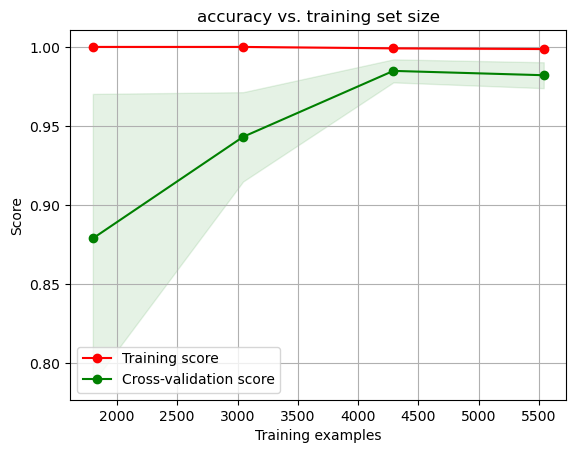

In [19]:
plot_learning_curve(best_logreg_model, "accuracy vs. training set size", X_train, y_train, cv=5)

### *Scoring and evaluating on the Train set*

In [21]:
y_train_pred=best_logreg_model.predict(X_train) ## Predicting the Train set

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3462
           1       1.00      1.00      1.00      3462

    accuracy                           1.00      6924
   macro avg       1.00      1.00      1.00      6924
weighted avg       1.00      1.00      1.00      6924



### *Scoring and evaluating on the Validation set*

'cross_val_predict' function returns the predicted labels for each sample when it's in the test set for each fold. Then, we can use these predictions along with the true labels to generate the classification report.

In [20]:
y_pred = cross_val_predict(best_logreg_model, X_train, y_train, cv=10, n_jobs=-1)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3462
           1       0.97      0.99      0.98      3462

    accuracy                           0.98      6924
   macro avg       0.98      0.98      0.98      6924
weighted avg       0.98      0.98      0.98      6924



Based on the score, we see that the model had performed both on the Train and Validation set.So we go futher for Scoring on the Test set

### *Score on the test set*

In [23]:
y_test_pred=best_logreg_model.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       865
           1       0.92      0.99      0.95       274

    accuracy                           0.98      1139
   macro avg       0.96      0.98      0.97      1139
weighted avg       0.98      0.98      0.98      1139



In [24]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[840  25]
 [  3 271]]


Confusion Matrix: 

[[true_negatives false_positives]                                                                                     
 [false_negatives true_positives]]

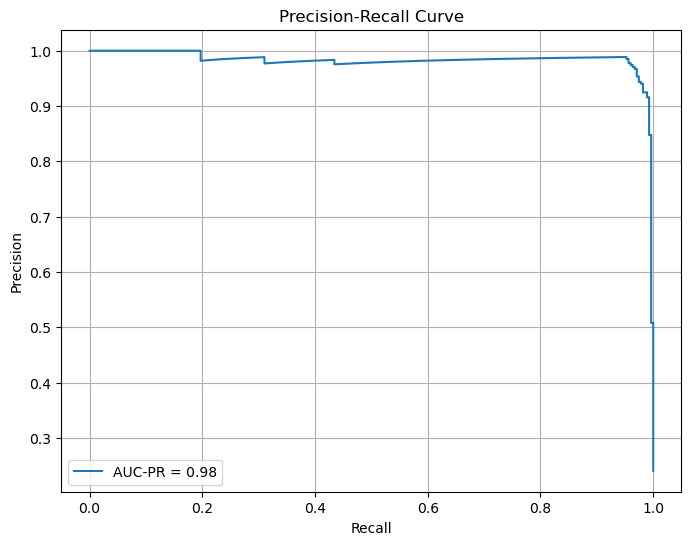

In [25]:
from sklearn.metrics import precision_recall_curve, auc
# Calculating precision and recall
y_probs = best_logreg_model.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_probs[:,1])

# Calculating AUC-PR
auc_pr = auc(recall, precision)

# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### Model 2: Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier() #random_forest_model

In [27]:
scores = cross_val_score(random_forest_model,  # random Forest Model
                         X_train,  # training data
                         y_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',   
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[0.96248196 0.96248196 0.96392496 0.99134199 0.99710983 0.99855491
 0.99132948 0.98410405 0.99566474 0.98988439]


In [28]:
print("Mean_score:",scores.mean(),"Std:",scores.std())

Mean_score: 0.983687827907481 Std: 0.014107184925452217


<module 'matplotlib.pyplot' from 'd:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

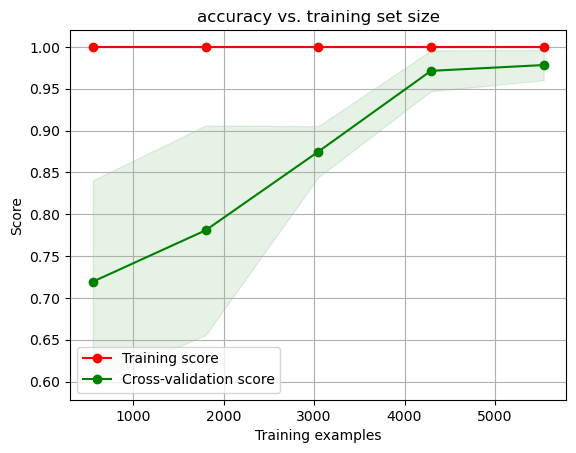

In [29]:
plot_learning_curve(random_forest_model, "accuracy vs. training set size", X_train, y_train, cv=5) ## learning curve

May be slightly Overfitting we go for searching the best parameter

In [30]:
params = {
    'n_estimators':[30,50,100] ,
    'max_depth':[3,5,10],
}

grid = GridSearchCV(
    random_forest_model,  # Model
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  #  score to be optimized
    cv=StratifiedKFold(n_splits=5),  # type of cross validation to use
)

In [31]:
logreg_detector = grid.fit(X_train, y_train)
mean_test_scores = logreg_detector.best_score_
print(mean_test_scores)
print(logreg_detector.best_params_)

0.9272105131362032
{'max_depth': 10, 'n_estimators': 50}


In [32]:
params = {
    'n_estimators':[30,50,100] ,
    'max_depth':[20,40,60],
}

grid = GridSearchCV(
    random_forest_model, 
    params,  
    refit=True,  
    n_jobs=-1, 
    scoring='accuracy',  
    cv=StratifiedKFold(n_splits=5),  
)

In [33]:
random_forest_detecter = grid.fit(X_train, y_train)
mean_test_scores = random_forest_detecter.best_score_
print(mean_test_scores)
print(random_forest_detecter.best_params_)

0.9755930594102795
{'max_depth': 60, 'n_estimators': 100}


In [34]:
best_params = random_forest_detecter.best_params_

# Creating a Random Forest model with the best parameters
best_rForest_model = RandomForestClassifier(**best_params)

# Training the model on your training data
best_rForest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=60)

### *Scoring and evaluating on the Train set*

In [36]:
y_train_pred=best_rForest_model.predict(X_train) ## Predicting the Train set

In [37]:

print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3462
           1       0.99      1.00      0.99      3462

    accuracy                           0.99      6924
   macro avg       0.99      0.99      0.99      6924
weighted avg       0.99      0.99      0.99      6924



### *Scoring and evaluating on the Validation set*

In [35]:
y_pred = cross_val_predict(best_rForest_model, X_train, y_train, cv=10, n_jobs=-1)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3462
           1       0.98      0.98      0.98      3462

    accuracy                           0.98      6924
   macro avg       0.98      0.98      0.98      6924
weighted avg       0.98      0.98      0.98      6924



<module 'matplotlib.pyplot' from 'd:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

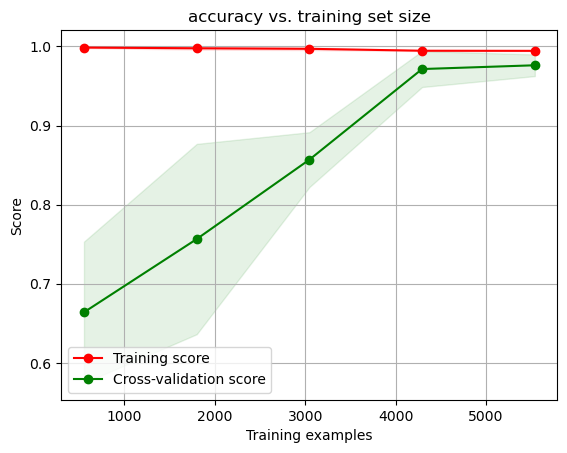

In [38]:
plot_learning_curve(best_rForest_model, "accuracy vs. training set size", X_train, y_train, cv=5)

### *Score on the test set*

In [39]:
y_test_pred=best_rForest_model.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       865
           1       0.92      0.94      0.93       274

    accuracy                           0.97      1139
   macro avg       0.95      0.96      0.96      1139
weighted avg       0.97      0.97      0.97      1139



In [40]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[844  21]
 [ 16 258]]


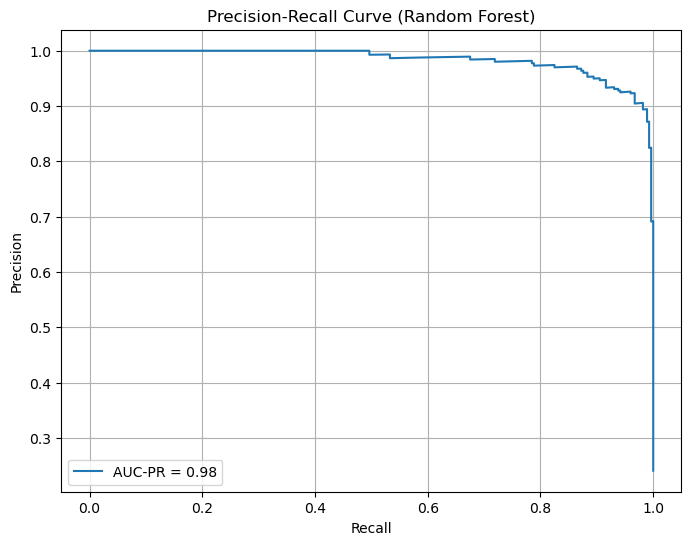

In [41]:
y_probs = best_rForest_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Calculating AUC-PR
auc_pr = auc(recall, precision)

# Plotting the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

### Model 3: SVC

In [42]:
from sklearn.svm import SVC

svc_model = SVC() #svc_model

In [43]:
scores = cross_val_score(svc_model,  # Model
                         X_train,  # training data
                         y_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # 
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[0.96392496 0.94805195 0.96825397 0.96969697 0.96965318 0.98265896
 0.96098266 0.96965318 0.97976879 0.9566474 ]


In [44]:
print("Mean_score:",scores.mean(),"Std:",scores.std())

Mean_score: 0.966929201177756 Std: 0.009710761315035489


<module 'matplotlib.pyplot' from 'd:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

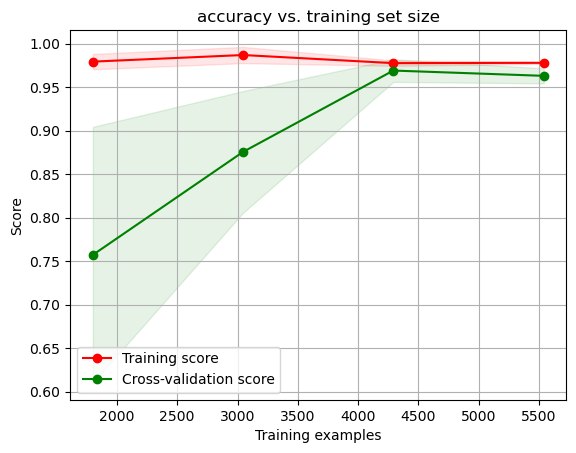

In [45]:
plot_learning_curve(svc_model, "accuracy vs. training set size", X_train, y_train, cv=5)

The Learning curve indicates the model is trained perfectly(neither overfit nor underfits).So we go for evaluating on train and validation set

In [46]:
best_svc_model = SVC(probability=True)

# Train the model on your training data
best_svc_model.fit(X_train, y_train)

SVC(probability=True)

### *Scoring and evaluating on the Validation set*

In [47]:
y_pred = cross_val_predict(best_svc_model, X_train, y_train, cv=10, n_jobs=-1)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3462
           1       0.95      0.99      0.97      3462

    accuracy                           0.97      6924
   macro avg       0.97      0.97      0.97      6924
weighted avg       0.97      0.97      0.97      6924



### *Scoring and evaluating on the Train set*

In [48]:
y_train_pred=best_svc_model.predict(X_train) ## Predicting the Train set

In [49]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3462
           1       0.96      1.00      0.98      3462

    accuracy                           0.98      6924
   macro avg       0.98      0.98      0.98      6924
weighted avg       0.98      0.98      0.98      6924



### *Score on the test set*

In [50]:
y_test_pred=best_svc_model.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       865
           1       0.85      0.96      0.91       274

    accuracy                           0.95      1139
   macro avg       0.92      0.96      0.94      1139
weighted avg       0.96      0.95      0.95      1139



In [51]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[820  45]
 [ 10 264]]


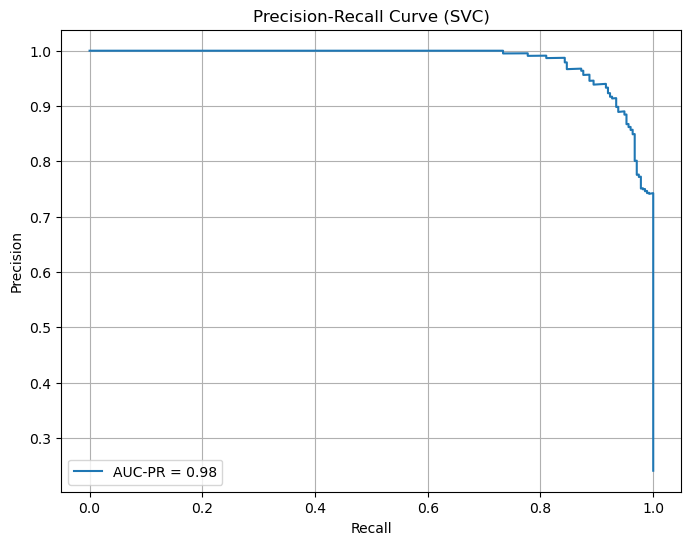

In [52]:
y_probs = best_svc_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Calculate AUC-PR
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SVC)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
Based on the scoring I would select logistic regression Model                                                  

The precision of my logreg classifier is 92% on test set                      
i.e Out of 100 times, my classifier will classify "true" Spam Mail as Spam 92 times  

The Recall of my classifier is 99%  on test set              
i.e 99% of the all "actual" Spam Mail were detected by my classifier.

**As our goal is to detect as much Spam Mail as possible so, Keeping our precesion above 90%  we should maximize Recall. In this case we are getting 99% Recall on the test data which is a great indication that our model is working Great**
